<a href="https://colab.research.google.com/github/masalha-alaa/name-classification-pytorch/blob/master/name_classification_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
import os
from google.colab import drive
!pip install unidecode
import unidecode

from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.utils.data as data_utils

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

from pathlib import Path
import zipfile
from pickle import load

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn import utils

from bisect import bisect_left

import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools
import copy
from math import ceil
from datetime import datetime

SEED = 42

In [104]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [105]:
# Use GPU if available

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}')

Running on cpu


In [106]:
# Extract data

DATA_DIR = Path("/content/gdrive/MyDrive/name-classification/")

if not os.path.exists(DATA_DIR / 'data'):
    print('Extracting data...')
    with zipfile.ZipFile(DATA_DIR / 'data.zip', 'r') as z:
        z.extractall(DATA_DIR)
    print('Done')

data = {}
for f in os.listdir(DATA_DIR / 'data'):
    # data[f.replace('.txt', '')] = [unidecode.unidecode(name.strip().lower()) for name in open(DATA_DIR / 'data' / f).readlines()]
    data[f.replace('.txt', '')] = [unidecode.unidecode(name.strip()) for name in open(DATA_DIR / 'data' / f).readlines()]
    # data[f.replace('.txt', '')] = [name.strip() for name in open(DATA_DIR / 'data' / f).readlines()]

print(f"{len(data)} files: {data.keys()}")

16 files: dict_keys(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Spanish', 'Vietnamese'])


In [107]:
# Take a look at some data

show_langs, show_names = 4, 5
for i,(k,v) in enumerate(data.items()):
    print(f'{k}: {[name for name in v[:show_names]]}')
    if i == show_langs:
        break

Arabic: ['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']
Chinese: ['Ang', 'Au-Yong', 'Bai', 'Ban', 'Bao']
Czech: ['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch']
Dutch: ['Aalsburg', 'Aalst', 'Aarle', 'Achteren', 'Achthoven']
English: ['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']


In [108]:
# Convert to dataframe for ease of use
DATA, LABEL = 'data', 'label'
df0 = pd.DataFrame(data=[[name, lang] for lang in data.keys() for name in data[lang]], columns=[DATA, LABEL]);
df_grouped_0 = df0.groupby(LABEL)
print(f'df1:\n{df_grouped_0.count()}')  # => it's massively biased!!!
print('')

MAX_SAMPLE_SIZE = df_grouped_0.count().max()[0]
# MAX_SAMPLE_SIZE = 700
df = df_grouped_0.apply(lambda g: g.sample(n=MAX_SAMPLE_SIZE if len(g) >= MAX_SAMPLE_SIZE else len(g))).reset_index(drop=True)
df_grouped = df.groupby(LABEL)
print(f'df2:\n{df_grouped.count()}')

df1:
            data
label           
Arabic      2000
Chinese      268
Czech        519
Dutch        297
English     3668
French       277
German       724
Greek        203
Italian      709
Japanese     991
Korean        94
Polish       139
Portuguese    74
Russian     9408
Spanish      298
Vietnamese    73

df2:
            data
label           
Arabic      2000
Chinese      268
Czech        519
Dutch        297
English     3668
French       277
German       724
Greek        203
Italian      709
Japanese     991
Korean        94
Polish       139
Portuguese    74
Russian     9408
Spanish      298
Vietnamese    73


In [109]:
df_train = df_grouped.sample(frac=0.8, random_state=SEED)
df_train_idx_set = set(df_train.index)
df_test = df.loc[[idx for idx in df.index if idx not in df_train_idx_set], :]
print(f"[Train]:\n{df_train.groupby(LABEL).count()}\n({df_train.shape[0]} entries)\n\nSamples:\n{df_train.sample(5, random_state=SEED)}")
print('')
print(f"[Test]:\n{df_test.groupby(LABEL).count()}\n({df_test.shape[0]} entries)\n\nSamples:\n{df_test.sample(5, random_state=SEED)}")

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

[Train]:
            data
label           
Arabic      1600
Chinese      214
Czech        415
Dutch        238
English     2934
French       222
German       579
Greek        162
Italian      567
Japanese     793
Korean        75
Polish       111
Portuguese    59
Russian     7526
Spanish      238
Vietnamese    58
(15791 entries)

Samples:
             data    label
13872  Mordkovich  Russian
1593        Totah   Arabic
3119       Jervis  English
4520     Kentwood  English
738          Tuma   Arabic

[Test]:
            data
label           
Arabic       400
Chinese       54
Czech        104
Dutch         59
English      734
French        55
German       145
Greek         41
Italian      142
Japanese     198
Korean        19
Polish        28
Portuguese    15
Russian     1882
Spanish       60
Vietnamese    15
(3951 entries)

Samples:
              data     label
15660  Yadrihinsky   Russian
10557        Mahno   Russian
9028       Asahara  Japanese
397          Nader    Arabic
12993    Gro

In [110]:
# encode labels

le = LabelEncoder()
encoded_lbls = le.fit_transform(list(data))  # list(data) makes a list of the dictionary's KEYS! (i.e. the countries)

def lbl_to_id(lbl):
    if torch.is_tensor(lbl):
        lbl = lbl.cpu().numpy()
    if isinstance(lbl, np.ndarray):
        return le.transform(lbl)[0]
    return le.transform([lbl])[0]

def id_to_lbl(lbl_id):
    if torch.is_tensor(lbl_id):
        lbl_id = lbl_id.cpu().numpy()
    if isinstance(lbl_id, np.ndarray):
        return le.inverse_transform(lbl_id)[0]
    return le.inverse_transform([lbl_id])[0]


# calculate classes weight because we have a huge imbalance
# both ways work more or less the same
# loss_weights = [1 / (len(df_grouped.get_group(g)) / df.shape[0]) for g in le.classes_]
loss_weights = compute_class_weight('balanced', classes=[lbl_to_id(g) for g in le.classes_], y=df[LABEL].apply(lbl_to_id).tolist())

In [111]:
# The unique characters in the files
vocab = sorted(set(' '.join(sum(data.values(), []))))
vocab_d = {k:v for v,k in enumerate(vocab)}
vocab_inv = {v:k for v,k in enumerate(vocab)}
print(f'{len(vocab)} unique characters')
print(vocab[:20])

59 unique characters
[' ', "'", ',', '-', '/', '1', ':', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']


## Text Vectorization

In [112]:
# letters one hot encoding
def ltr_one_hot(ltr, num_cats):
    # num_cats: number of categories for the one hot encoding (usually len(vocab))
    def char_to_id(ch):
        return vocab_d[ch]
    return torch.nn.functional.one_hot(torch.LongTensor([char_to_id(ltr)]), num_cats)

# line one hot
def line_to_one_hot_tensor(line, num_cats):
    # num_cats: number of categories for the one hot encoding (usually len(vocab))
    line_one_hot = None
    for i, ltr in enumerate(line):
        if line_one_hot is None:
            line_one_hot = ltr_one_hot(ltr, num_cats)
            # print(line_one_hot.shape)
        else:
            line_one_hot = torch.cat([line_one_hot, ltr_one_hot(ltr, num_cats)])
    # return torch.unsqueeze(line_one_hot, 1)
    return line_one_hot.type(torch.FloatTensor)

def one_hot_tensor_to_line(one_hot_tensor):
    line = ''
    for one_hot_ltr in one_hot_tensor:
        line += vocab_inv[torch.argmax(one_hot_ltr).item()]
    return line

In [113]:
class MyDataset(Dataset):
    def __init__(self, dataframe):
        self.sequences = dataframe[DATA].apply(lambda name: line_to_one_hot_tensor(name, len(vocab))).tolist()
        self.labels = dataframe[LABEL].apply(lbl_to_id).tolist()
    
    def __getitem__(self, i):
        return self.sequences[i], self.labels[i]
    
    def __len__(self):
        return len(self.sequences)


training_dataset = MyDataset(df_train)
test_dataset = MyDataset(df_test)

train_loader = DataLoader(training_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [114]:
line_to_one_hot_tensor("slim shady", len(vocab)).shape

torch.Size([10, 59])

# Model

In [115]:
class RNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = 128
        self.num_layers = 1
        self.rnn = nn.RNN(input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def init_hidden(self):
        return torch.randn(self.num_layers, 1, self.hidden_size).to(device), None  # to make it match with LSTM

    def forward(self, x, h0):
        out, h0 = self.rnn(x, h0)
        # out = out.reshape(out.shape[0], -1)
        out = out[:, -1, :]
        out = self.softmax(self.fc(out))
        return out, h0, None  # the 3rd arg is to make it match with LSTM api


class ManualRNN(nn.Module):
    # from: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
    # (with modifications)
    def __init__(self, input_size, num_classes):
        super(ManualRNN, self).__init__()
        
        self.hidden_size = 128
        self.i2h = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.i2o = nn.Linear(input_size + self.hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size).to(device), None  # to make it match with LSTM

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 2)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = output[:, -1, :]
        output = self.softmax(output)
        return output, hidden, None  # the 3rd arg is to make it match with LSTM api


class LSTM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = 128
        self.num_layers = 1
        self.rnn = nn.LSTM(input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def init_hidden(self):
        h0 = torch.randn(self.num_layers, 1, self.hidden_size).to(device)
        c0 = torch.randn(self.num_layers, 1, self.hidden_size).to(device)
        return h0, c0

    def forward(self, x, h0, c0):
        out, hidden = self.rnn(x, (h0, c0))
        h0, c0 = hidden
        # out = out.reshape(out.shape[0], -1)
        out = out[:, -1, :]
        out = self.softmax(self.fc(out))
        return out, h0, c0


class GRU(nn.Module):
    def __init__(self, input_size, num_classes):
        super(GRU, self).__init__()
        self.hidden_size = 128
        self.num_layers = 1
        self.rnn = nn.GRU(input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def init_hidden(self):
        return torch.randn(self.num_layers, 1, self.hidden_size).to(device), None  # to make it match with LSTM

    def forward(self, x, h0):
        out, hidden = self.rnn(x, h0)
        # out = out.reshape(out.shape[0], -1)
        out = out[:, -1, :]
        out = self.softmax(self.fc(out))
        return out, hidden, None  # the 3rd arg is to make it match with LSTM api


# model = RNN(len(vocab), len(data)).to(device)
# model = LSTM(len(vocab), len(data)).to(device)
# model = GRU(len(vocab), len(data)).to(device)
# model = ManualRNN(len(vocab), len(data)).to(device)
# => moved to the bottom

# Loss and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss(weight=torch.FloatTensor(loss_weights).to(device))
learning_rate = 0.005
# learning_rate = 0.0001
optimizer = lambda mdl: torch.optim.SGD(mdl.parameters(), lr=learning_rate)  
# optimizer = lambda mdl: torch.optim.Adam(mdl.parameters(), lr=learning_rate)

In [116]:
def softmax_to_prediction(softmax_output, classes):
    return classes[torch.argmax(softmax_output).item()]

In [117]:
# one step test
model_test = ManualRNN(len(vocab), len(data)).to(device)
input_tensor = ltr_one_hot('a', len(vocab)).to(device).unsqueeze(0)  # unsqueeze to imitate batch of size 1
input_tensor = input_tensor.type(torch.FloatTensor).to(device)
h0, c0 = model_test.init_hidden()

if c0 is None:
    output, next_hidden, _ = model_test(input_tensor, h0)
else:
    # LSTM
    output, next_hidden, cell_state = model_test(input_tensor.type(torch.FloatTensor), h0, c0)

print(f'input_tensor {input_tensor.shape}:\n{input_tensor}')
print(f'output {output.size()}')
print(f'next_hidden {next_hidden.size()}')

print(f'\nPrediction: {id_to_lbl(softmax_to_prediction(output, encoded_lbls))}')
model_test = None

input_tensor torch.Size([1, 1, 59]):
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]]])
output torch.Size([1, 16])
next_hidden torch.Size([1, 1, 128])

Prediction: Spanish


In [118]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues,
                        figsize=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
    """

    def calc_acc(cm):
        correct = 0
        for i in range(len(cm)):
            correct += cm[i][i]
        return correct / cm.sum(axis=1).sum()
    
    cm_acc = calc_acc(cm)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    if figsize is None:
        figsize = (30,10)
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(f'{title}\nAccuracy: {cm_acc*100:.2f}%')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [119]:
def evaluate(model, optim, line_tensor, category_tensor, train=False, log=False):
    h0, c0 = model.init_hidden()
    
    for ltr_one_hot in line_tensor[0]:
        if c0 is None:
            output, h0, _ = model(torch.reshape(ltr_one_hot, (1,1,-1)), h0)
        else:
            # LSTM
            output, h0, c0 = model(torch.reshape(ltr_one_hot, (1,1,-1)), h0, c0)
    
    if log:
        print(f'output {output.shape}:\n{output}')
        print(f'category_tensor {category_tensor.shape}:\n{category_tensor}')
    loss = criterion(output, category_tensor)
    
    if train:
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    return output, loss.item()

In [120]:
def train(model):
    ts = datetime.now()
    print(ts)
    print('')

    optim = optimizer(model)
    train_losses, validation_losses = [], []
    epochs = 30
    model.train(mode=True)
    for epoch in range(epochs):
        epoch_train_loss, epoch_validation_loss = 0, 0
        for name_tensor, label in train_loader:
            name_tensor, label = name_tensor.to(device), label.to(device)

            output, loss = evaluate(model, optim, name_tensor, label, train=True)
            epoch_train_loss += loss
        
        train_losses.append(epoch_train_loss / len(training_dataset))

        # validation eval
        model.train(mode=False)  # enter eval mode
        for val_data, val_labels in test_loader:
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            val_output, val_loss = evaluate(model, None, val_data, val_labels)
            epoch_validation_loss += val_loss
            
        validation_losses.append(epoch_validation_loss / len(test_dataset))
        model.train(mode=True)  # exit eval mode, re-enter training mode
            
        print(f"Epoch {epoch}: Training Loss: {train_losses[-1]:.4f}, Validation Loss: {validation_losses[-1]:.4f}")
            

    print('')
    print(f'Training Time: {datetime.now() - ts}')
    return train_losses, validation_losses

In [121]:
def test(model):
    y_true, y_pred = [], []
    model.train(mode=False)  # enter eval mode
    # with torch.no_grad():  # locally disable gradient tracking? (no, should not do it in RNN, becaues we do want grads to accumulate!)
    test_num = -1
    print_cnt, print_num = 0, 20
    for i, (val_data, val_labels) in enumerate(test_loader):
        val_data, val_labels = val_data.to(device), val_labels.to(device)
        
        val_output, _ = evaluate(model, None, val_data, val_labels)
        pred_id = softmax_to_prediction(val_output, encoded_lbls)
        
        y_true.append(val_labels.item())
        y_pred.append(pred_id)

        pred = id_to_lbl(pred_id)

        name = one_hot_tensor_to_line(val_data.squeeze(0))
        lbl = id_to_lbl(val_labels)
        
        if print_cnt < print_num:
            print(f"Name: {name:<16} Label: {lbl:<20} Prediction: {pred:<16} -- {'CORRECT' if lbl == pred else 'INCORRECT'}")
            print_cnt += 1
        
        if i == test_num:
            break
    
    return y_true, y_pred

In [122]:
def plot_progress(train_losses, validation_losses):
    plt.figure()
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.show()

ManualRNN(
  (i2h): Linear(in_features=187, out_features=128, bias=True)
  (i2o): Linear(in_features=187, out_features=16, bias=True)
  (softmax): LogSoftmax(dim=1)
)


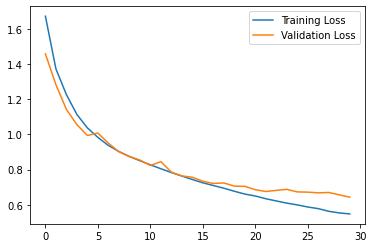

Name: Dobropolsky      Label: Russian              Prediction: Russian          -- CORRECT
Name: Foster           Label: English              Prediction: English          -- CORRECT
Name: Atherley         Label: English              Prediction: English          -- CORRECT
Name: Shahmin          Label: Russian              Prediction: Russian          -- CORRECT
Name: Jelyabovsky      Label: Russian              Prediction: Russian          -- CORRECT
Name: Enshin           Label: Russian              Prediction: Russian          -- CORRECT
Name: Val              Label: Russian              Prediction: Russian          -- CORRECT
Name: Gronchi          Label: Italian              Prediction: Japanese         -- INCORRECT
Name: Djisev           Label: Russian              Prediction: Russian          -- CORRECT
Name: Veselkov         Label: Russian              Prediction: Russian          -- CORRECT
Name: Vertkov          Label: Russian              Prediction: Russian          -- CORRE

In [126]:
manual_rnn_model = ManualRNN(len(vocab), len(data)).to(device)
print(manual_rnn_model)
train_losses, validation_losses = train(manual_rnn_model)
plot_progress(train_losses, validation_losses)
_,_ = test(manual_rnn_model)

RNN(
  (rnn): RNN(59, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=16, bias=True)
  (softmax): LogSoftmax(dim=1)
)


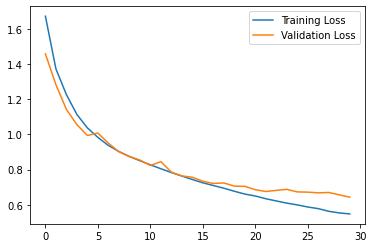

Name: Najjar           Label: Arabic               Prediction: Arabic           -- CORRECT
Name: Layton           Label: English              Prediction: English          -- CORRECT
Name: Takeshita        Label: Japanese             Prediction: Japanese         -- CORRECT
Name: Katsibin         Label: Russian              Prediction: Russian          -- CORRECT
Name: Vedenkin         Label: Russian              Prediction: Russian          -- CORRECT
Name: Rocchi           Label: Italian              Prediction: Italian          -- CORRECT
Name: Iskandaryan      Label: Russian              Prediction: Russian          -- CORRECT
Name: Orritt           Label: English              Prediction: English          -- CORRECT
Name: Vaughan          Label: English              Prediction: English          -- CORRECT
Name: Babkeev          Label: Russian              Prediction: Russian          -- CORRECT
Name: Gansky           Label: Russian              Prediction: Russian          -- CORRECT

In [127]:
rnn_model = RNN(len(vocab), len(data)).to(device)
print(rnn_model)
train_losses, validation_losses = train(rnn_model)
plot_progress(train_losses, validation_losses)
_,_ = test(rnn_model)

LSTM(
  (rnn): LSTM(59, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=16, bias=True)
  (softmax): LogSoftmax(dim=1)
)


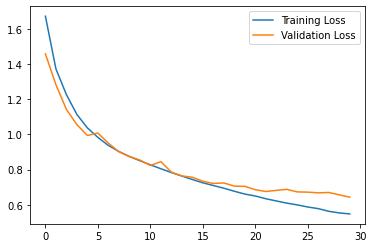

Name: Ghannam          Label: Arabic               Prediction: Arabic           -- CORRECT
Name: Deeley           Label: English              Prediction: English          -- CORRECT
Name: Close            Label: Greek                Prediction: English          -- INCORRECT
Name: Pochkaev         Label: Russian              Prediction: Russian          -- CORRECT
Name: Kalakos          Label: Greek                Prediction: Greek            -- CORRECT
Name: Pahtanov         Label: Russian              Prediction: Russian          -- CORRECT
Name: Dubman           Label: Russian              Prediction: Russian          -- CORRECT
Name: Yeomans          Label: English              Prediction: English          -- CORRECT
Name: Jovnerik         Label: Russian              Prediction: Russian          -- CORRECT
Name: Hamidulin        Label: Russian              Prediction: Russian          -- CORRECT
Name: Wasem            Label: Arabic               Prediction: Arabic           -- CORRE

In [128]:
lstm_model = LSTM(len(vocab), len(data)).to(device)
print(lstm_model)
train_losses, validation_losses = train(lstm_model)
plot_progress(train_losses, validation_losses)
_,_ = test(lstm_model)

GRU(
  (rnn): GRU(59, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=16, bias=True)
  (softmax): LogSoftmax(dim=1)
)
2021-08-04 10:28:28.268167

Epoch 0: Training Loss: 1.5416, Validation Loss: 1.3454
Epoch 1: Training Loss: 1.2513, Validation Loss: 1.1672
Epoch 2: Training Loss: 1.1139, Validation Loss: 1.0701
Epoch 3: Training Loss: 1.0328, Validation Loss: 0.9980
Epoch 4: Training Loss: 0.9792, Validation Loss: 0.9472
Epoch 5: Training Loss: 0.9353, Validation Loss: 0.9270
Epoch 6: Training Loss: 0.9029, Validation Loss: 0.8900
Epoch 7: Training Loss: 0.8713, Validation Loss: 0.8717
Epoch 8: Training Loss: 0.8429, Validation Loss: 0.8477
Epoch 9: Training Loss: 0.8176, Validation Loss: 0.8317
Epoch 10: Training Loss: 0.7933, Validation Loss: 0.7901
Epoch 11: Training Loss: 0.7640, Validation Loss: 0.7762
Epoch 12: Training Loss: 0.7419, Validation Loss: 0.7632
Epoch 13: Training Loss: 0.7200, Validation Loss: 0.7503
Epoch 14: Training Loss: 0.6995, Validation Lo

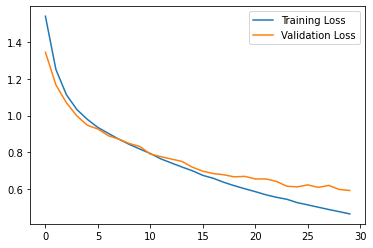

Name: Atlanov          Label: Russian              Prediction: Russian          -- CORRECT
Name: Bekhterev        Label: Russian              Prediction: Russian          -- CORRECT
Name: Dobroslavin      Label: Russian              Prediction: Russian          -- CORRECT
Name: Dougherty        Label: English              Prediction: English          -- CORRECT
Name: Abano            Label: Spanish              Prediction: Italian          -- INCORRECT
Name: Jalybin          Label: Russian              Prediction: Russian          -- CORRECT
Name: Vaca             Label: Czech                Prediction: Italian          -- INCORRECT
Name: Peter            Label: German               Prediction: German           -- CORRECT
Name: Vingilevsky      Label: Russian              Prediction: Russian          -- CORRECT
Name: Noschese         Label: Italian              Prediction: Italian          -- CORRECT
Name: Guirguis         Label: Arabic               Prediction: Arabic           -- COR

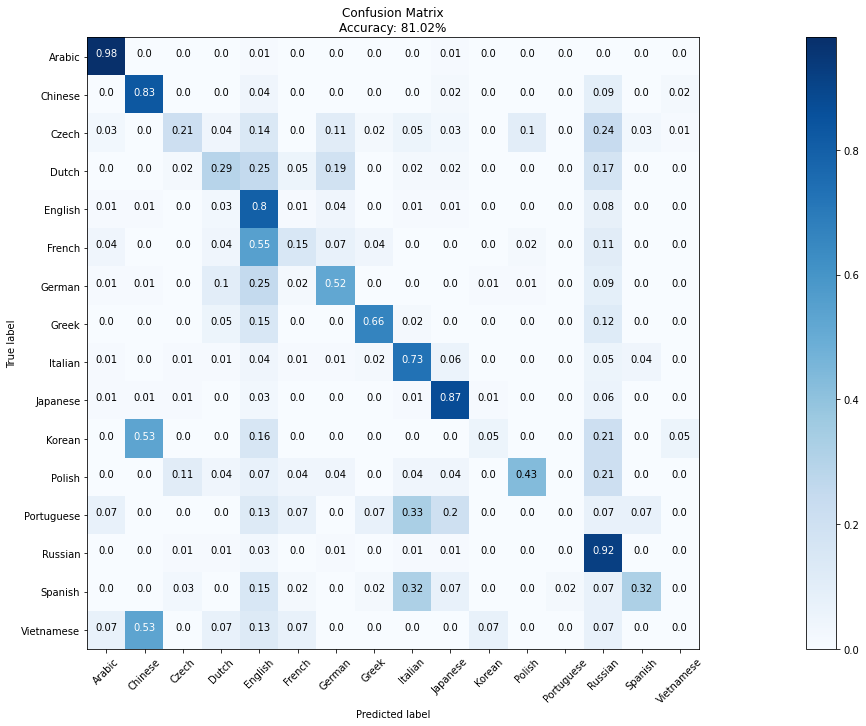

In [99]:
gru_model = GRU(len(vocab), len(data)).to(device)
print(gru_model)
train_losses, validation_losses = train(gru_model)
plot_progress(train_losses, validation_losses)
y_true, y_pred = test(gru_model)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plot_confusion_matrix(cm=cm, classes=le.classes_, title='Confusion Matrix', normalize=True)